In [1]:
import pandas as pd
import numpy as np
import random
import swifter
random.seed(42)
from matplotlib import pyplot as plt

# 0. Read in data

In [2]:
df = pd.read_csv('raw data/tripData2013/trip_data_1.csv') # file for january
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [3]:
print(len(set(df['medallion'])), len(set(df['hack_license'])))

13426 32224


# 1. Examing data
## (This part can be skipped if you don't want to see what the dataset looks like, for preprocessing, go directly to part 2)

<Figure size 432x288 with 0 Axes>

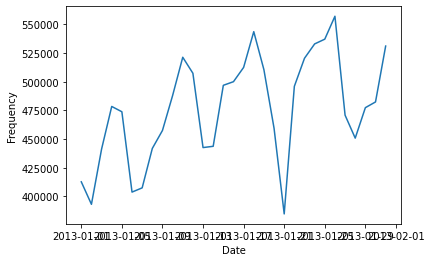

In [4]:
aggregate_df = df.groupby([df['pickup_datetime'].dt.date])['pickup_datetime'].agg('count')
assert aggregate_df.sum() == len(df) # sanity check: sum of frequencies of all days of january == all rides in January

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(aggregate_df.index, aggregate_df)
ax.set_xlabel('Date')
ax.set_ylabel('Frequency')
#plt.savefig('jan_date_vs_rides_dist.png')
plt.show()

#### Look at how many trips in each hour in january

In [30]:
aggregate_time = df.groupby([df['pickup_datetime'].dt.hour])['pickup_datetime'].agg('count')
aggregate_time, len(aggregate_time)

(pickup_datetime
 0     531347
 1     401365
 2     307314
 3     227515
 4     164900
 5     143100
 6     304640
 7     546976
 8     694630
 9     700817
 10    658908
 11    675108
 12    723139
 13    721154
 14    757578
 15    743037
 16    647936
 17    767050
 18    934546
 19    941645
 20    866823
 21    833123
 22    806661
 23    677303
 Name: pickup_datetime, dtype: int64,
 24)

<Figure size 432x288 with 0 Axes>

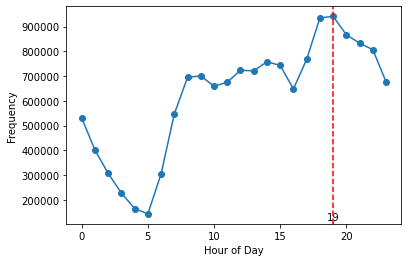

In [31]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(aggregate_time.index, aggregate_time, marker='o')

peak_hour = np.argmax(np.array(aggregate_time))

ax.axvline(x=peak_hour, linestyle='--', color='r')
ax.tick_params('x', which='minor', direction='in', pad=-12)
ax.xaxis.set_ticks([peak_hour], minor=True)
ax.xaxis.set_ticklabels(list(map(str, [peak_hour])), minor=True)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Frequency')
#plt.savefig('jan_hour_vs_rides_dist.png')
plt.show()

#### Look at how many trips in each hour on last day

<Figure size 432x288 with 0 Axes>

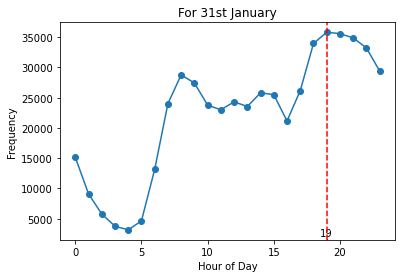

In [32]:
aggregate_time_last_day = df.groupby([df['pickup_datetime'][df['pickup_datetime'].dt.day == 31].dt.hour])['pickup_datetime'].agg('count')

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(aggregate_time_last_day.index, aggregate_time_last_day, marker='o')

peak_hour = np.argmax(np.array(aggregate_time_last_day))

ax.axvline(x=peak_hour, linestyle='--', color='r')
ax.tick_params('x', which='minor', direction='in', pad=-12)
ax.xaxis.set_ticks([peak_hour], minor=True)
ax.xaxis.set_ticklabels(list(map(str, [peak_hour])), minor=True)
ax.set_title('For 31st January')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Frequency')
#plt.savefig('31_jan_hour_vs_rides_dist.png')
plt.show()

# 2. Processing Data

## 2.1 Only take out 7 pm on january 31 (peak hour that we focus on)

In [5]:
peak_hour = 19
peak_day = 31

print('number of entries before:',df.shape[0])
filtered_df = df[np.logical_and(df['pickup_datetime'].dt.hour == peak_hour,df['pickup_datetime'].dt.day == peak_day)]
print('number of entries after:', filtered_df.shape[0])

number of entries before: 14776615
number of entries after: 35814


## 2.2 Weed out the invalid latitude and longitudes

In [6]:
#first print some information about coordinates before (with invalid stuff)
print((np.min(filtered_df['pickup_latitude']), np.min(filtered_df['dropoff_latitude']), np.max(filtered_df['pickup_latitude']), np.max(filtered_df['dropoff_latitude'])))
print((min(filtered_df['pickup_longitude'].min(), filtered_df['dropoff_longitude'].min()), max(filtered_df['pickup_longitude'].max(), filtered_df['dropoff_longitude'].max())))

(-0.0030420001, -0.001663, 41.453693, 41.716991)
(-81.699997, 0.0015670001)


In [7]:
def valid_coordinate_bool(series, lower, upper):
    """
    series is a list of pandas series objects
    lower and upper are lower and upper bound for coordinates to be valid
    """
    final_condition = np.logical_and(np.abs(series[0]) > lower, np.abs(series[0]) < upper)
    for i in range(1, len(series)):
        final_condition = np.logical_and(final_condition, np.logical_and(np.abs(series[i]) > lower, np.abs(series[i]) < upper))
    return final_condition

In [8]:
#Only keep the latitude and longitudes within a certain range, in other words, getting rid of invalid coordinates
valid_latitudes = valid_coordinate_bool([filtered_df['pickup_latitude'], filtered_df['dropoff_latitude']], 40.4, 41)
valid_longitudes = valid_coordinate_bool([filtered_df['pickup_longitude'], filtered_df['dropoff_longitude']], 73, 75)
valid_rows_bool = np.logical_and(valid_latitudes, valid_longitudes)

#number of valids, total number, number of invalids
np.count_nonzero(valid_rows_bool), len(filtered_df), len(filtered_df) - np.count_nonzero(valid_rows_bool)

(35109, 35814, 705)

In [9]:
filtered_df = filtered_df.loc[filtered_df.index[valid_rows_bool]]
#multiply the pick up and drop off longitudes by -1
filtered_df['pickup_longitude'][filtered_df['pickup_longitude'] > 0] *= -1
filtered_df['dropoff_longitude'][filtered_df['dropoff_longitude'] > 0] *= -1
filtered_df.head()

C:\Users\dchen\AppData\Local\Temp\ipykernel_19836\3027352479.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['pickup_longitude'][filtered_df['pickup_longitude'] > 0] *= -1
C:\Users\dchen\AppData\Local\Temp\ipykernel_19836\3027352479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['dropoff_longitude'][filtered_df['dropoff_longitude'] > 0] *= -1


,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
8009861,6B53BBA9567F90BD8A4130FEE57F703A,A21EF85E38B13F676E69C40A0127654B,VTS,1,NaN,2013-01-31 19:21:00,2013-01-31 19:32:00,1,660,4.4,-74.004677,40.711876,-73.972374,40.742809
8029916,E565EF3C83240654D540CBAA0D7C96EE,4269094FA5A341993B6707B5E1200AAA,CMT,1,N,2013-01-31 19:20:55,2013-01-31 19:49:11,1,1694,5.9,-73.976387,40.748592,-73.965439,40.678673
8034189,79584E2DA4A76EA45C482EA2B1C1B220,3B1803457E6CD3936B2C32CB856AD272,CMT,1,N,2013-01-31 19:17:16,2013-01-31 19:26:00,3,523,1.2,-73.983322,40.750206,-73.971024,40.762066
8036336,171BF6AD2C32D927735A7A5ADB516512,6CB8F868A9A20D3FAB2B3307C841C00B,CMT,1,N,2013-01-31 19:54:32,2013-01-31 20:14:15,1,1183,11.0,-73.872978,40.774025,-73.975807,40.676292
8037309,FB30B64440B4A7B8DBA9903C7598AD90,A4897540F0711AE1BC2C76A348883100,CMT,1,N,2013-01-31 19:56:28,2013-01-31 20:06:14,1,586,1.1,-73.977638,40.758900,-73.990395,40.767120


In [10]:
assert len(filtered_df) == np.count_nonzero(valid_rows_bool)

In [11]:
#first print some information about coordinates before (with invalid stuff)
print((np.min(filtered_df['pickup_latitude']), np.min(filtered_df['dropoff_latitude']), np.max(filtered_df['pickup_latitude']), np.max(filtered_df['dropoff_latitude'])))
print((min(filtered_df['pickup_longitude'].min(), filtered_df['dropoff_longitude'].min()), max(filtered_df['pickup_longitude'].max(), filtered_df['dropoff_longitude'].max())))

(40.427174, 40.429337, 40.944237, 40.991241)
(-74.449997, -73.610985)


## 2.3 Assign drivers random initial coordinates

In [12]:
possible_lat_long_indices = np.arange(-4, 5)
print(possible_lat_long_indices)
factor = 0.005

# we create a mesh around the pickup location with each line separated by 0.005 degree of lat or long or both

driver_latitude_coords = pd.Series([np.random.choice(possible_lat_long_indices) \
                                    for _ in range(len(filtered_df))],
                                    index=filtered_df.index) * factor
driver_longitude_coords = pd.Series([np.random.choice(possible_lat_long_indices) \
                                    for _ in range(len(filtered_df))],
                                    index=filtered_df.index) * factor

driver_init_latitudes = filtered_df['pickup_latitude'] + driver_latitude_coords
driver_init_longitudes = filtered_df['pickup_longitude'] + driver_longitude_coords

filtered_df['driver_init_longitude'] = driver_init_longitudes
filtered_df['driver_init_latitude'] = driver_init_latitudes

filtered_df.head()

[-4 -3 -2 -1  0  1  2  3  4]


,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,driver_init_longitude,driver_init_latitude
8009861,6B53BBA9567F90BD8A4130FEE57F703A,A21EF85E38B13F676E69C40A0127654B,VTS,1,NaN,2013-01-31 19:21:00,2013-01-31 19:32:00,1,660,4.4,-74.004677,40.711876,-73.972374,40.742809,-74.014677,40.726876
8029916,E565EF3C83240654D540CBAA0D7C96EE,4269094FA5A341993B6707B5E1200AAA,CMT,1,N,2013-01-31 19:20:55,2013-01-31 19:49:11,1,1694,5.9,-73.976387,40.748592,-73.965439,40.678673,-73.956387,40.763592
8034189,79584E2DA4A76EA45C482EA2B1C1B220,3B1803457E6CD3936B2C32CB856AD272,CMT,1,N,2013-01-31 19:17:16,2013-01-31 19:26:00,3,523,1.2,-73.983322,40.750206,-73.971024,40.762066,-73.988322,40.745206
8036336,171BF6AD2C32D927735A7A5ADB516512,6CB8F868A9A20D3FAB2B3307C841C00B,CMT,1,N,2013-01-31 19:54:32,2013-01-31 20:14:15,1,1183,11.0,-73.872978,40.774025,-73.975807,40.676292,-73.882978,40.764025
8037309,FB30B64440B4A7B8DBA9903C7598AD90,A4897540F0711AE1BC2C76A348883100,CMT,1,N,2013-01-31 19:56:28,2013-01-31 20:06:14,1,586,1.1,-73.977638,40.758900,-73.990395,40.767120,-73.972638,40.748900


## 2.4 Put data into bins by coordinates

In [13]:
min_latitude = min(np.min(filtered_df['pickup_latitude']), np.min(filtered_df['dropoff_latitude']), np.min(filtered_df['driver_init_latitude']))
max_latitude = max(np.max(filtered_df['pickup_latitude']), np.max(filtered_df['dropoff_latitude']), np.max(filtered_df['driver_init_latitude']))
min_longitude = min(np.min(filtered_df['pickup_longitude']), np.min(filtered_df['dropoff_longitude']), np.min(filtered_df['driver_init_longitude']))
max_longitude = max(np.max(filtered_df['pickup_longitude']), np.max(filtered_df['dropoff_longitude']), np.max(filtered_df['driver_init_longitude']))
print(min_latitude, min_longitude, max_latitude, max_longitude)

40.412174 -74.459997 40.991241 -73.610834


In [14]:
np.arange(min_longitude, max_longitude, 0.05), np.arange(min_latitude, max_latitude, 0.05)

(array([-74.459997, -74.409997, -74.359997, -74.309997, -74.259997,
        -74.209997, -74.159997, -74.109997, -74.059997, -74.009997,
        -73.959997, -73.909997, -73.859997, -73.809997, -73.759997,
        -73.709997, -73.659997]),
 array([40.412174, 40.462174, 40.512174, 40.562174, 40.612174, 40.662174,
        40.712174, 40.762174, 40.812174, 40.862174, 40.912174, 40.962174]))

In [15]:
def coordinates_to_bin(val, coordinate_type):
    steps = (val - min_latitude)/0.05 if coordinate_type == 'latitude' else (val - min_longitude)/0.05
#     if np.isclose(int(steps), steps, rtol=0, atol=0.00000001):
#         steps += 1
    return int(steps)

In [16]:
filtered_df['pickup_lat_bin'] = filtered_df['pickup_latitude'].swifter.apply(coordinates_to_bin, args=('latitude',))
filtered_df['pickup_long_bin'] = filtered_df['pickup_longitude'].swifter.apply(coordinates_to_bin, args=('longitude',))
filtered_df['dropoff_lat_bin'] = filtered_df['dropoff_latitude'].swifter.apply(coordinates_to_bin, args=('latitude',))
filtered_df['dropoff_long_bin'] = filtered_df['dropoff_longitude'].swifter.apply(coordinates_to_bin, args=('longitude',))
filtered_df['init_lat_bin'] = filtered_df['driver_init_latitude'].swifter.apply(coordinates_to_bin, args=('latitude',))
filtered_df['init_long_bin'] = filtered_df['driver_init_longitude'].swifter.apply(coordinates_to_bin, args=('longitude',))

Pandas Apply:   0%|          | 0/35109 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/35109 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/35109 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/35109 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/35109 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/35109 [00:00<?, ?it/s]

## 2.5 Assign Race and gender
### 2.5.1 Assign Drivers race and gender

In [17]:
white_ratio = 0.7
female_ratio = 0.2

drivers = np.unique(df['hack_license'])
drivers_races = np.array(['black'] * len(drivers))
drivers_gender = np.array(['m'] * len(drivers))
random.seed(42)
drivers_races[random.sample(list(np.arange(len(drivers))), k=int(len(drivers) * white_ratio))] = ['white'] # 2:1 black:white
random.seed(42)
drivers_gender[random.sample(list(np.arange(len(drivers))), k=int(len(drivers) * female_ratio))] = ['f'] # 5:1 males:females

random.seed(42)
drivers_gender[random.sample(list(np.arange(len(drivers))), k=int(len(drivers)/6))]


hack_id_to_race = dict(zip(drivers, drivers_races))
hack_id_to_gender = dict(zip(drivers, drivers_gender))
(np.count_nonzero(drivers_races == 'black')/np.count_nonzero(drivers_races == 'white'),
 np.count_nonzero(drivers_gender == 'm')/np.count_nonzero(drivers_gender == 'f'))


driver_race_series = filtered_df['hack_license'].map(hack_id_to_race)
driver_gender_series = filtered_df['hack_license'].map(hack_id_to_gender)

np.count_nonzero(driver_race_series == 'black'), np.count_nonzero(driver_race_series == 'white')

filtered_df['driver_race'] = driver_race_series
filtered_df['driver_gender'] = driver_gender_series
filtered_df.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,driver_init_longitude,driver_init_latitude,pickup_lat_bin,pickup_long_bin,dropoff_lat_bin,dropoff_long_bin,init_lat_bin,init_long_bin,driver_race,driver_gender
8009861,6B53BBA9567F90BD8A4130FEE57F703A,A21EF85E38B13F676E69C40A0127654B,VTS,1,NaN,2013-01-31 19:21:00,2013-01-31 19:32:00,1,660,4.4,...,-74.014677,40.726876,5,9,6,9,6,8,white,m
8029916,E565EF3C83240654D540CBAA0D7C96EE,4269094FA5A341993B6707B5E1200AAA,CMT,1,N,2013-01-31 19:20:55,2013-01-31 19:49:11,1,1694,5.9,...,-73.956387,40.763592,6,9,5,9,7,10,black,m
8034189,79584E2DA4A76EA45C482EA2B1C1B220,3B1803457E6CD3936B2C32CB856AD272,CMT,1,N,2013-01-31 19:17:16,2013-01-31 19:26:00,3,523,1.2,...,-73.988322,40.745206,6,9,6,9,6,9,white,m
8036336,171BF6AD2C32D927735A7A5ADB516512,6CB8F868A9A20D3FAB2B3307C841C00B,CMT,1,N,2013-01-31 19:54:32,2013-01-31 20:14:15,1,1183,11.0,...,-73.882978,40.764025,7,11,5,9,7,11,black,m
8037309,FB30B64440B4A7B8DBA9903C7598AD90,A4897540F0711AE1BC2C76A348883100,CMT,1,N,2013-01-31 19:56:28,2013-01-31 20:06:14,1,586,1.1,...,-73.972638,40.748900,6,9,7,9,6,9,white,m


### 2.5.2 Assign Requests race and gender

In [18]:
requests_gender = np.array(['f'] * len(filtered_df))
requests_race = np.array(['black'] * len(filtered_df))
random.seed(42)
requests_race[random.sample(list(np.arange(len(requests_race))), k=int(len(requests_race)/3))] = 'white'

r1_indices = np.where(requests_race == 'black')[0]
random.seed(42)
random_choice_r1 = random.sample(list(r1_indices), k=int(len(r1_indices)/2))
requests_gender[random_choice_r1] = 'm'
print (np.count_nonzero(requests_gender == 'm'))
assert np.count_nonzero(requests_gender == 'm') == len(random_choice_r1)
r2_indices = np.where(requests_race == 'white')[0]
random.seed(42)
random_choice_r2 = random.sample(list(r2_indices), k=int(len(r2_indices)/2))
requests_gender[random_choice_r2] = 'm'



assert len(r1_indices) + len(r2_indices) == len(requests_race)
assert len(set(list(r1_indices)).intersection(set(list(r2_indices)))) == 0
assert len(set(list(random_choice_r1)).intersection(set(list(random_choice_r2)))) == 0



(np.count_nonzero(requests_gender == 'm'), np.count_nonzero(requests_gender == 'f'),
     np.count_nonzero(requests_race == 'white'), np.count_nonzero(requests_race == 'black'))


filtered_df['requests_gender'] = requests_gender
filtered_df['requests_race'] = requests_race
filtered_df.head()

11703


,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,pickup_lat_bin,pickup_long_bin,dropoff_lat_bin,dropoff_long_bin,init_lat_bin,init_long_bin,driver_race,driver_gender,requests_gender,requests_race
8009861,6B53BBA9567F90BD8A4130FEE57F703A,A21EF85E38B13F676E69C40A0127654B,VTS,1,NaN,2013-01-31 19:21:00,2013-01-31 19:32:00,1,660,4.4,...,5,9,6,9,6,8,white,m,f,black
8029916,E565EF3C83240654D540CBAA0D7C96EE,4269094FA5A341993B6707B5E1200AAA,CMT,1,N,2013-01-31 19:20:55,2013-01-31 19:49:11,1,1694,5.9,...,6,9,5,9,7,10,black,m,m,black
8034189,79584E2DA4A76EA45C482EA2B1C1B220,3B1803457E6CD3936B2C32CB856AD272,CMT,1,N,2013-01-31 19:17:16,2013-01-31 19:26:00,3,523,1.2,...,6,9,6,9,6,9,white,m,f,black
8036336,171BF6AD2C32D927735A7A5ADB516512,6CB8F868A9A20D3FAB2B3307C841C00B,CMT,1,N,2013-01-31 19:54:32,2013-01-31 20:14:15,1,1183,11.0,...,7,11,5,9,7,11,black,m,f,white
8037309,FB30B64440B4A7B8DBA9903C7598AD90,A4897540F0711AE1BC2C76A348883100,CMT,1,N,2013-01-31 19:56:28,2013-01-31 20:06:14,1,586,1.1,...,6,9,7,9,6,9,white,m,m,black


## 2.6 Drop unused columns

In [19]:
print(filtered_df.columns)

cols_to_drop = ['medallion','vendor_id', 'rate_code', 'store_and_fwd_flag', 'passenger_count']
cols_maybe_drop = ['trip_time_in_secs','trip_distance']
cols_to_drop += cols_maybe_drop
try:
    filtered_df.drop(columns=cols_to_drop, inplace=True)
except:
    print('ERROR: columns most likely already dropped')
print(filtered_df.columns)

Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_time_in_secs', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'driver_init_longitude', 'driver_init_latitude',
       'pickup_lat_bin', 'pickup_long_bin', 'dropoff_lat_bin',
       'dropoff_long_bin', 'init_lat_bin', 'init_long_bin', 'driver_race',
       'driver_gender', 'requests_gender', 'requests_race'],
      dtype='object')
Index(['hack_license', 'pickup_datetime', 'dropoff_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'driver_init_longitude', 'driver_init_latitude',
       'pickup_lat_bin', 'pickup_long_bin', 'dropoff_lat_bin',
       'dropoff_long_bin', 'init_lat_bin', 'init_long_bin', 'driver_race',
       'driver_gender', 'requests_gender', 'requests_race'],
      dtype='object')


## 3 Final Clean up and save filtered data

In [20]:
filtered_df['pickup_datetime'] = pd.to_datetime(filtered_df['pickup_datetime'])
filtered_df['dropoff_datetime'] = pd.to_datetime(filtered_df['dropoff_datetime'])

filtered_df.to_csv('filtered data/filtered_df.csv',index=False)